<a href="https://colab.research.google.com/github/Ankitarora2/TechnoCulture/blob/main/Another_copy_of_OnboardingHelper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**START FROM THE BEGINNING FOR CLI AND ABLATION_STUDY**

# Serve the model using vLLM

In [24]:
!pip install dspy-ai vllm

In [25]:
# Run server in foreground
# !python -m vllm.entrypoints.openai.api_server --model TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ --quantization awq

# Run server in the background
!nohup python -m vllm.entrypoints.openai.api_server --model TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ --quantization awq > server.log 2>&1 &
# stdout is redirected to a file `server.log` using `> server.log`.
# We use a quantized model prepared using AWQ quantization

In [33]:
# Run this cell again and again to monitor the status of the server.
# The server can take a few mintues to start.
# Once the server has started, you will see logs such as this:
# INFO 02-10 07:16:43 llm_engine.py:877] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%
!tail server.log

INFO 02-16 00:26:37 llm_engine.py:877] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%
INFO 02-16 00:26:47 llm_engine.py:877] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%
INFO 02-16 00:26:57 llm_engine.py:877] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%
INFO 02-16 00:27:07 llm_engine.py:877] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%
INFO 02-16 00:27:17 llm_engine.py:877] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running

In [34]:
# Once the server is up and running, this should work
!curl http://localhost:8000/v1/models

{"object":"list","data":[{"id":"TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ","object":"model","created":1708043293,"owned_by":"vllm","root":"TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ","parent":null,"permission":[{"id":"modelperm-1f3fdc2f72284b989d728cc9113d1b46","object":"model_permission","created":1708043293,"allow_create_engine":false,"allow_sampling":true,"allow_logprobs":true,"allow_search_indices":false,"allow_view":true,"allow_fine_tuning":false,"organization":"*","group":null,"is_blocking":false}]}]}

# DSPy: 𝗗eclarative 𝗦elf-improving Language 𝗣rograms

In [35]:
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune

In [36]:
lm = dspy.HFClientVLLM(model="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ", port=8000, url="http://localhost")

dspy.settings.configure(lm=lm)

In [10]:
predict = dspy.Predict('question -> answer')

predict(question="What is the capital of Germany?")

Prediction(
    answer='Berlin'
)

# Onboarding Task: Build a reasonably complex pipeline
- Implement a bunch of signatures, and modules
- Use more than one teleprompter to compile and optimize the prompt pipeline
- Important to use kNN Few Shot and Chain of thought as part of the solution
- End with an ablation study showing the importance of various parameters and modules with matplotlib plots
- Use assert and suggust from dspy to further improve your dspy programs, document improvement

> No need to use RAG for this task.

In [65]:
%%writefile HRP.py

#ALL THE IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN
import argparse
from dspy.teleprompt import BayesianSignatureOptimizer

#MODEL
model_name="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ"
lm = dspy.HFClientVLLM(model=model_name, port=8000, url="http://localhost")
dspy.settings.configure(lm=lm)

#DATSETS FOR OPTIMIZERS
train = [
    ('Why does my stomach hurt?', 'Drink chamomile tea and eat ginger biscuits.'),
    ('I have a headache, what should I do?', 'Take a nap and drink plenty of water.'),
    ('My throat is sore, what can I do about it?', 'Gargle with warm salt water and drink honey lemon tea.'),
    ('What should I do for a stuffy nose?', 'Use a saline nasal spray and inhale steam from a bowl of hot water.'),
    ('I feel nauseous, what should I eat?', 'Try eating crackers and sipping on ginger ale.'),
    ('How can I relieve muscle pain?', 'Take a warm bath and apply a heating pad to the affected area.'),
    ('What can I do for a minor burn?', 'Run cool water over the burn and apply aloe vera gel.'),
    ('My back hurts, what can I do to alleviate the pain?', 'Stretch gently and apply a warm compress to your back.'),
    ('I have a splinter, what is the best way to remove it?', 'Soak the affected area in warm, soapy water and carefully use tweezers to remove the splinter.'),
    ('What can I do to calm my nerves?', 'Practice deep breathing exercises and try mindfulness meditation techniques.'),
]


dev = [
    ('How can I get rid of a cold quickly?', 'Drink plenty of fluids and get plenty of rest.'),
    ('What should I do for an upset stomach?', 'Avoid spicy and greasy foods, and drink peppermint tea.'),
    ('I have a minor cut, what is the best way to treat it?', 'Clean the cut with water, and cover it with a bandage.'),
    ('My eyes feel tired and strained, what can I do?', 'Take frequent breaks from screens.'),
    ('What can I do for a bee sting?', 'Remove the stinger if it\'s still in the skin, wash the area with water.'),
    ('How can I relieve sunburn pain?', 'Take a cool bath or shower, drink plenty of water to stay hydrated.'),
    ('I have a minor abrasion, what should I do?', 'Clean the wound with mild soap and water.'),
    ('My tooth is aching, what can I do to ease the pain?', 'Rinse your mouth with warm salt water.'),
    ('How can I alleviate menstrual cramps?', 'Apply a heating pad to your abdomen and take a warm bath.'),
]

# Convert the dataset into DSPy Examples
trainset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in train]
devset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in dev]

# Print the lengths of trainset and devset
#print(len(trainset), len(devset))

# Access an example from trainset and devset
train_example = trainset[0]
dev_example = devset[0]
# print(train_example.question)



def should_be_correct(que, rem):
  check=dspy.Predict("question -> answer")
  result=check(question=f"Is this {rem}; a correct remedy for {que}. Return 0 for False and 1 for True.")
  if result.answer==0:
    return False
  else:
    return True

class RemedySuggest(dspy.Signature):
    """Suggest one best home remedy for the provided symptoms (only natural methods)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Suggested home remedy (less than 200 characters)")


class HomeRemedyPipelineAssertions(dspy.Module):
    def __init__(self, assert_on=True):
        super().__init__()
        self.assert_on = assert_on
        self.remedy_suggest = dspy.ChainOfThought(RemedySuggest)

    def forward(self, question, **kwargs):
        suggested_remedy = self.remedy_suggest(question=question)

        if self.assert_on:
            dspy.Suggest(
                should_be_correct(question, suggested_remedy),
                "The suggested remedy should be correct.",
                target_module=RemedySuggest
            )

        return suggested_remedy


class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="Only True or False")


def metric(gold, pred, trace=None):
    question, answer, remedy = gold.question, gold.answer, pred.answer

    correctness = f"The given remedy {remedy} will be effective for this issue {question}. The gold answer is {answer}"
    informative = f"For this issue {question} is the given {remedy} informative. The gold answer is {answer}"

    correct = dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=correctness)
    informative = dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=informative)

    correctness_score = correct.assessment_answer
    info_score = informative.assessment_answer
    score = 0

    if correctness_score == "True":
        score += 1

    if info_score == "True":
        score += 1

    return score / 2.0


# Define your devset and kwargs here
# Replace placeholders with your actual development dataset and any additional keyword arguments you need for evaluation

kwargs = dict(display_progress=True, display_table=5)

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)

# Define function to evaluate pipeline
def evaluate_pipeline(model_name, assertion=True, bayesian=True):
    home_remedy = HomeRemedyPipelineAssertions()

    # Compile the pipeline with specified configurations
    if assertion and bayesian:
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(home_remedy, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Optimized Pipeline"
    elif assertion and not bayesian:
        compiled_pipeline = home_remedy
        config_label = "Without Bayesian"
    elif not assertion and bayesian:
        without_assertion=HomeRemedyPipelineAssertions(assert_on=False)
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(without_assertion, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Without Assertion"
    else:
        without_assertion_and_bayesian=HomeRemedyPipelineAssertions(assert_on=False)
        compiled_pipeline = without_assertion_and_bayesian
        config_label = "No Assertion and No Bayesian"

    # Evaluate the compiled pipeline
    eval_score = evaluate_on_hotpotqa(compiled_pipeline, metric=metric)
    return eval_score, config_label


# Run the evaluation for each configuration
def run_ablation_study(model_name, disable_assertion=False, disable_bayesian=False):
    scores = []
    config_labels = []

    for assertion in [True, False]:
        if disable_assertion and not assertion:
            continue
        for bayesian in [True, False]:
            if disable_bayesian and not bayesian:
                continue
            eval_score, config_label = evaluate_pipeline(model_name, assertion=assertion, bayesian=bayesian)
            scores.append(eval_score)
            config_labels.append(config_label)

    return scores, config_labels

def use_pipeline_as_user(model_name, question):
    home_remedy = HomeRemedyPipelineAssertions()
    result = home_remedy(question=question)
    print("Suggested remedy:", result.answer)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Pipeline for suggesting home remedies.")
    parser.add_argument("--assertion", type=bool, default=True, help="Whether to include assertion in the pipeline. Default: True")
    parser.add_argument("--bayesian", type=bool, default=True, help="Whether to use Bayesian optimization. Default: True")
    parser.add_argument("--run-ablation", action="store_true", help="Perform an ablation study.")
    parser.add_argument("--model-name", type=str, default="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ", help="Name of the language model. Default: TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ")
    parser.add_argument("--user-question", type=str, help="Question to use the pipeline as a user.")
    parser.add_argument("--disable-assertion", action="store_true", help="Disable assertion in the pipeline during ablation study.")
    parser.add_argument("--disable-bayesian", action="store_true", help="Disable Bayesian optimization in the pipeline during ablation study.")
    args = parser.parse_args()

    if args.run_ablation:
        scores, config_labels = run_ablation_study(args.model_name, disable_assertion=args.disable_assertion, disable_bayesian=args.disable_bayesian)
        # Plotting the results
        x = np.arange(len(config_labels))
        plt.bar(x, scores)
        plt.xlabel('Configuration')
        plt.ylabel('Evaluation Score')
        plt.title('Ablation Study Results')
        plt.xticks(x, config_labels, rotation=45)
        plt.tight_layout()
        plt.show()
    elif args.user_question:
        use_pipeline_as_user(args.model_name, args.user_question)
    else:
        eval_score, config_label = evaluate_pipeline(args.model_name, assertion=args.assertion, bayesian=args.bayesian)
        print(f"Evaluation Score: {eval_score}, Configuration: {config_label}")


Overwriting HRP.py


In [60]:
!python HRP.py --run-ablation --disable-assertion


10 9
 33% 3/9 [00:00<00:00, 117.67it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
 33% 3/9 [00:00<00:00, 158.30it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
 33% 3/9 [00:00<00:00, 155.04it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
 33% 3/9 [00:00<00:00, 166.61it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
[I 2024-02-16 00:57:04,430] A new study created in memory with name: no-name-6c3e1149-9ed9-4c91-9b5e-fa719de6769a
Average Metric: 9.0 / 9  (100.0): 100% 9/9 [00:00<00:00, 171.57it/s]
Average Metric: 9.0 / 9  (100.0%)
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in orde

In [64]:
!python HRP.py --user-question "My chest hurts"

10 9
Suggested remedy: Applying a warm compress on your chest can help soothe the pain. You can also try taking deep breaths and practicing relaxation techniques to help ease the discomfort.


In [66]:
!python HRP.py --user-question "Severe Headache" --bayesian False

Suggested remedy: Drink plenty of water and rest in a quiet, dark room.


In [70]:
!python HRP.py --user-question "Menstrual Cramps"

Suggested remedy: Apply a heating pad to your lower abdomen and consume ginger tea to help alleviate menstrual cramps.


In [37]:

train = [
    ('Why does my stomach hurt?', 'Drink chamomile tea and eat ginger biscuits.'),
    ('I have a headache, what should I do?', 'Take a nap and drink plenty of water.'),
    ('My throat is sore, what can I do about it?', 'Gargle with warm salt water and drink honey lemon tea.'),
    ('What should I do for a stuffy nose?', 'Use a saline nasal spray and inhale steam from a bowl of hot water.'),
    ('I feel nauseous, what should I eat?', 'Try eating crackers and sipping on ginger ale.'),
    ('How can I relieve muscle pain?', 'Take a warm bath and apply a heating pad to the affected area.'),
    ('What can I do for a minor burn?', 'Run cool water over the burn and apply aloe vera gel.'),
    ('My back hurts, what can I do to alleviate the pain?', 'Stretch gently and apply a warm compress to your back.'),
    ('I have a splinter, what is the best way to remove it?', 'Soak the affected area in warm, soapy water and carefully use tweezers to remove the splinter.'),
    ('What can I do to calm my nerves?', 'Practice deep breathing exercises and try mindfulness meditation techniques.'),
]


dev = [
    ('How can I get rid of a cold quickly?', 'Drink plenty of fluids and get plenty of rest.'),
    ('What should I do for an upset stomach?', 'Avoid spicy and greasy foods, and drink peppermint tea.'),
    ('I have a minor cut, what is the best way to treat it?', 'Clean the cut with water, and cover it with a bandage.'),
    ('My eyes feel tired and strained, what can I do?', 'Take frequent breaks from screens.'),
    ('What can I do for a bee sting?', 'Remove the stinger if it\'s still in the skin, wash the area with water.'),
    ('How can I relieve sunburn pain?', 'Take a cool bath or shower, drink plenty of water to stay hydrated.'),
    ('I have a minor abrasion, what should I do?', 'Clean the wound with mild soap and water.'),
    ('My tooth is aching, what can I do to ease the pain?', 'Rinse your mouth with warm salt water.'),
    ('How can I alleviate menstrual cramps?', 'Apply a heating pad to your abdomen and take a warm bath.'),
]

# Convert the dataset into DSPy Examples
# Convert the dataset into DSPy Examples
trainset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in train]
devset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in dev]

# Print the lengths of trainset and devset
print(len(trainset), len(devset))


# Print the lengths of trainset and devset
print(len(trainset), len(devset))

# Access an example from trainset and devset
train_example = trainset[0]
dev_example = devset[0]


print(train_example.question)

10 9
10 9
Why does my stomach hurt?


In [ ]:
from dspy.teleprompt import BayesianSignatureOptimizer
from dspy.evaluate.evaluate import Evaluate


allopathic_medicines=["Paracetamol",
    "Ibuprofen",
    "Aspirin",
    "Omeprazole",
    "Metformin",
    "Simvastatin",
    "Amlodipine",
    "Levothyroxine",
    "Lisinopril",]


class RemedySuggest(dspy.Signature):
    """Suggest one best home remedy for the provided symptoms (only natural methods)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Suggested home remedy (less than 200 characters)")


class HomeRemedyPipelineAssertions(dspy.Module):
    def __init__(self):
        super().__init__()
        self.remedy_suggest = dspy.ChainOfThought(RemedySuggest)

    def forward(self, question, **kwargs):
        suggested_remedy = self.remedy_suggest(question=question)

        dspy.Assert(
            not any(keyword in suggested_remedy.answer.lower() for keyword in allopathic_medicines),
            "It's recommended to stick to home remedies. Avoid suggesting medicines.",
            target_module=RemedySuggest
        )

        return suggested_remedy

class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="Only True or False")

def metric(gold, pred, trace=None):
    question, answer, remedy = gold.question, gold.answer, pred.answer

    correctness=f"The given remedy {remedy} will be effective for this issue {question}. The gold answer is {answer}"
    informative=f"For this issue {question} is the given {remedy} informative. The gold answer is {answer}"


    correct=dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=correctness)
    informative=dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=informative)

    correctness_score=correct.assessment_answer
    info_score=informative.assessment_answer
    score=0

    if correctness_score=="True":
      score+=1

    if info_score=="True":
      score+=1

    return score/2.0


home_remedy=HomeRemedyPipelineAssertions()
teleprompter = BayesianSignatureOptimizer( metric=metric, n=5, init_temperature=1.0)
kwargs = dict( display_progress=True, display_table=0)
compiled_prompt_opt = teleprompter.compile(home_remedy, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)



# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)

evaluate_on_hotpotqa(home_remedy, metric=metric) #normal
evaluate_on_hotpotqa(compiled_prompt_opt, metric=metric) #after optimizer

 33%|███▎      | 3/9 [00:00<00:00, 208.80it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:00<00:00, 248.83it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:00<00:00, 277.14it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:00<00:00, 247.30it/s]
[I 2024-02-16 00:07:33,358] A new study created in memory with name: no-name-9c8a2608-e9e3-4d1a-a887-52f726dc0b70


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 188.17it/s]
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)
[I 2024-02-16 00:07:33,419] Trial 0 finished with value: 100.0 and parameters: {'132519671987120_predictor_instruction': 1, '132519671987120_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 9.0 / 9  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad to the lower abdomen, take over-the-counter pain relievers, and try to relax. --- Question: How can I treat a sunburn? A suggested home remedy for your issue is Apply aloe vera gel to the affected area and take cool showers or baths. --- Question: How can I relieve constipation? A suggested home remedy for your issue is Drink plenty of water informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alle

Average Metric: 7.0 / 9  (77.8): 100%|██████████| 9/9 [00:00<00:00, 182.75it/s]
[I 2024-02-16 00:07:33,481] Trial 1 finished with value: 77.78 and parameters: {'132519671987120_predictor_instruction': 3, '132519671987120_predictor_demos': 2}. Best is trial 0 with value: 100.0.


Average Metric: 7.0 / 9  (77.8%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Take over-the-counter pain relievers, apply a heating pad to your abdomen, and take a warm bath. --- Question: How can I alleviate a cough? One effective solution to alleviate your discomfort is... Drink warm liquids, such as tea or broth, and use a humidifier to moisten the air. --- Question: How can I alleviate a cold? Reasoning: informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual cramps. We can 

Average Metric: 7.5 / 9  (83.3): 100%|██████████| 9/9 [00:00<00:00, 187.93it/s]
[I 2024-02-16 00:07:33,540] Trial 2 finished with value: 83.33 and parameters: {'132519671987120_predictor_instruction': 0, '132519671987120_predictor_demos': 0}. Best is trial 0 with value: 100.0.


Average Metric: 7.5 / 9  (83.3%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad on your lower abdomen, drink chamomile or raspberry leaf tea, or consume ginger tea to alleviate menstrual cramps. informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual cramps. We can apply a heating pad on our lower abdomen, drink chamomile or raspberry leaf tea, or consume ginger tea. These methods can help in reducing the pain and discomfort caused by menstrual cramps.

Assessm

Average Metric: 8.5 / 9  (94.4): 100%|██████████| 9/9 [00:00<00:00, 180.03it/s]
[I 2024-02-16 00:07:33,605] Trial 3 finished with value: 94.44 and parameters: {'132519671987120_predictor_instruction': 0, '132519671987120_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 8.5 / 9  (94.4%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad to the lower abdomen, take over-the-counter pain relievers, and try to relax. --- Question: How can I relieve constipation? Answer: Drink plenty of water and eat high-fiber foods. --- Question: How can I soothe a sunburn? Answer: Apply aloe vera gel to the affected area and take cool showers. --- Question: How can I reduce the informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual 

Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 177.00it/s]
[I 2024-02-16 00:07:33,669] Trial 4 finished with value: 100.0 and parameters: {'132519671987120_predictor_instruction': 3, '132519671987120_predictor_demos': 3}. Best is trial 0 with value: 100.0.


Average Metric: 9.0 / 9  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Take over-the-counter pain relievers, apply a heating pad to the lower abdomen, and practice relaxation techniques. --- Question: How can I relieve constipation? One effective solution to alleviate your discomfort is... Drink plenty of water and eat high-fiber foods. --- Question: How can I relieve heartburn? One effective solution to alleviate your discomfort is... Eat smaller meals informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step b

Average Metric: 7.5 / 9  (83.3): 100%|██████████| 9/9 [00:00<00:00, 175.55it/s]


Average Metric: 7.5 / 9  (83.3%)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,get rid of a cold quickly. We can try some natural remedies that can help boost the immune system and alleviate symptoms.,"To get rid of a cold quickly, try drinking warm lemon water with honey, getting plenty of rest, and consuming foods rich in vitamin C...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.",alleviate the symptoms of an upset stomach. We can try some natural methods to soothe the stomach and reduce discomfort.,"Try drinking ginger tea or peppermint tea, which can help soothe your stomach and reduce nausea. You can also try eating a small, bland meal...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, prevent infection, and promote healing.","Clean the wound with mild soap and water, apply an antiseptic ointment, and cover it with a sterile bandage.",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,alleviate the patient's eye strain. We can suggest natural methods to relax the eyes and reduce strain.,"Try the 20-20-20 rule: every 20 minutes, look at something 20 feet away for 20 seconds. This can help relax your eyes and reduce strain....",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","alleviate the pain and swelling caused by a bee sting. We can try applying a cold compress to reduce inflammation, and then use a natural...","Apply a cold compress to the sting site for 10-15 minutes, then make a paste of honey or baking soda and apply it to the...",0.0


Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 151.26it/s]

Average Metric: 9.0 / 9  (100.0%)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,"get rid of a cold quickly. We can drink plenty of fluids, get plenty of rest, and eat healthy foods.","Drink plenty of fluids, get plenty of rest, and eat healthy foods. --- Question: How can I get rid of a cold quickly? Reasoning: Let's...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.","alleviate the symptoms. We can try to eat bland foods, drink clear liquids, and avoid lying down.","Eat bland foods, drink clear liquids, and avoid lying down. --- Question: How can I relieve a headache? A suggested home remedy for your issue...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, apply an antiseptic, and cover it with a sterile bandage.","Clean the wound with mild soap and water, apply an antiseptic, and cover it with a sterile bandage. --- Question: I have a headache, what...",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,"relieve eye strain. We can take breaks from looking at screens, blink frequently, and use lubricating eye drops.","Take breaks from looking at screens, blink frequently, and use lubricating eye drops. --- Question: I have a fever, what can I do to lower...",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","reduce the swelling and pain. We can remove the stinger, clean the area with soap and water, and apply a cold compress.","Remove the stinger, clean the area with soap and water, and apply a cold compress. --- Question: How can I relieve constipation? A suggested home...",1.0


100.0

In [ ]:
from dspy.evaluate.evaluate import Evaluate

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)

evaluate_on_hotpotqa(home_remedy, metric=metric)
evaluate_on_hotpotqa(compiled_prompt_opt, metric=metric)



  0%|          | 0/9 [00:00<?, ?it/s]

Average Metric: 1.0 / 1  (100.0):   0%|          | 0/9 [00:00<?, ?it/s]

Average Metric: 2.0 / 2  (100.0):  11%|█         | 1/9 [00:00<00:00, 52.69it/s]

Average Metric: 3.0 / 3  (100.0):  22%|██▏       | 2/9 [00:00<00:00, 69.12it/s]

Average Metric: 4.0 / 4  (100.0):  33%|███▎      | 3/9 [00:00<00:00, 83.48it/s]

Average Metric: 4.0 / 5  (80.0):  44%|████▍     | 4/9 [00:00<00:00, 86.78it/s] 

Average Metric: 4.5 / 6  (75.0):  56%|█████▌    | 5/9 [00:00<00:00, 86.68it/s]

Average Metric: 5.5 / 7  (78.6):  67%|██████▋   | 6/9 [00:00<00:00, 90.20it/s]

Average Metric: 6.5 / 8  (81.2):  78%|███████▊  | 7/9 [00:00<00:00, 88.56it/s]

Average Metric: 7.5 / 9  (83.3): 100%|██████████| 9/9 [00:00<00:00, 98.56it/s]


Average Metric: 7.5 / 9  (83.3%)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,get rid of a cold quickly. We can try some natural remedies that can help boost the immune system and alleviate symptoms.,"To get rid of a cold quickly, try drinking warm lemon water with honey, getting plenty of rest, and consuming foods rich in vitamin C...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.",alleviate the symptoms of an upset stomach. We can try some natural methods to soothe the stomach and reduce discomfort.,"Try drinking ginger tea or peppermint tea, which can help soothe your stomach and reduce nausea. You can also try eating a small, bland meal...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, prevent infection, and promote healing.","Clean the wound with mild soap and water, apply an antiseptic ointment, and cover it with a sterile bandage.",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,alleviate the patient's eye strain. We can suggest natural methods to relax the eyes and reduce strain.,"Try the 20-20-20 rule: every 20 minutes, look at something 20 feet away for 20 seconds. This can help relax your eyes and reduce strain....",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","alleviate the pain and swelling caused by a bee sting. We can try applying a cold compress to reduce inflammation, and then use a natural...","Apply a cold compress to the sting site for 10-15 minutes, then make a paste of honey or baking soda and apply it to the...",0.0




  0%|          | 0/9 [00:00<?, ?it/s]

Average Metric: 1.0 / 1  (100.0):   0%|          | 0/9 [00:00<?, ?it/s]

Average Metric: 2.0 / 2  (100.0):  11%|█         | 1/9 [00:00<00:00, 46.71it/s]

Average Metric: 3.0 / 3  (100.0):  22%|██▏       | 2/9 [00:00<00:00, 56.26it/s]

Average Metric: 4.0 / 4  (100.0):  33%|███▎      | 3/9 [00:00<00:00, 61.62it/s]

Average Metric: 5.0 / 5  (100.0):  44%|████▍     | 4/9 [00:00<00:00, 67.11it/s]

Average Metric: 6.0 / 6  (100.0):  56%|█████▌    | 5/9 [00:00<00:00, 68.76it/s]

Average Metric: 7.0 / 7  (100.0):  67%|██████▋   | 6/9 [00:00<00:00, 67.04it/s]

Average Metric: 8.0 / 8  (100.0):  78%|███████▊  | 7/9 [00:00<00:00, 69.88it/s]

Average Metric: 8.0 / 8  (100.0):  89%|████████▉ | 8/9 [00:00<00:00, 77.82it/s]

Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 76.93it/s]

Average Metric: 9.0 / 9  (100.0%)



/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,"get rid of a cold quickly. We can drink plenty of fluids, get plenty of rest, and eat healthy foods.","Drink plenty of fluids, get plenty of rest, and eat healthy foods. --- Question: How can I get rid of a cold quickly? Reasoning: Let's...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.","alleviate the symptoms. We can try to eat bland foods, drink clear liquids, and avoid lying down.","Eat bland foods, drink clear liquids, and avoid lying down. --- Question: How can I relieve a headache? A suggested home remedy for your issue...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, apply an antiseptic, and cover it with a sterile bandage.","Clean the wound with mild soap and water, apply an antiseptic, and cover it with a sterile bandage. --- Question: I have a headache, what...",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,"relieve eye strain. We can take breaks from looking at screens, blink frequently, and use lubricating eye drops.","Take breaks from looking at screens, blink frequently, and use lubricating eye drops. --- Question: I have a fever, what can I do to lower...",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","reduce the swelling and pain. We can remove the stinger, clean the area with soap and water, and apply a cold compress.","Remove the stinger, clean the area with soap and water, and apply a cold compress. --- Question: How can I relieve constipation? A suggested home...",1.0


100.0

In [40]:
def should_be_correct(que, rem):
  check=dspy.Predict("question -> answer")
  result=check(question=f"Is this {rem}; a correct remedy for {que}. Return 0 for False and 1 for True.")
  if result==0:
    return False
  else:
    return True

should_be_correct("I am feeling low", "exercise")

1


1

 33%|███▎      | 3/9 [00:16<00:32,  5.41s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:45<01:31, 15.17s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:45<01:30, 15.12s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:42<01:24, 14.13s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


[I 2024-02-16 00:34:57,005] A new study created in memory with name: no-name-95fec8d4-23cb-4a3b-a85a-172e2c7b6d30
Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [02:01<00:00, 13.53s/it]
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)
[I 2024-02-16 00:36:58,780] Trial 0 finished with value: 100.0 and parameters: {'133040323547616_predictor_instruction': 1, '133040323547616_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 9.0 / 9  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad to the lower abdomen, take over-the-counter pain relievers, and try to relax. --- Question: How can I treat a sunburn? A suggested home remedy for your issue is Apply aloe vera gel to the affected area and take cool showers or baths. --- Question: How can I relieve constipation? A suggested home remedy for your issue is Drink plenty of water informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alle

Average Metric: 7.0 / 9  (77.8): 100%|██████████| 9/9 [01:58<00:00, 13.12s/it]
[I 2024-02-16 00:38:56,879] Trial 1 finished with value: 77.78 and parameters: {'133040323547616_predictor_instruction': 3, '133040323547616_predictor_demos': 2}. Best is trial 0 with value: 100.0.


Average Metric: 7.0 / 9  (77.8%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Take over-the-counter pain relievers, apply a heating pad to your abdomen, and take a warm bath. --- Question: How can I alleviate a cough? One effective solution to alleviate your discomfort is... Drink warm liquids, such as tea or broth, and use a humidifier to moisten the air. --- Question: How can I alleviate a cold? Reasoning: informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual cramps. We can 

Average Metric: 7.5 / 9  (83.3): 100%|██████████| 9/9 [01:44<00:00, 11.65s/it]
[I 2024-02-16 00:40:41,766] Trial 2 finished with value: 83.33 and parameters: {'133040323547616_predictor_instruction': 0, '133040323547616_predictor_demos': 0}. Best is trial 0 with value: 100.0.


Average Metric: 7.5 / 9  (83.3%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad on your lower abdomen, drink chamomile or raspberry leaf tea, or consume ginger tea to alleviate menstrual cramps. informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual cramps. We can apply a heating pad on our lower abdomen, drink chamomile or raspberry leaf tea, or consume ginger tea. These methods can help in reducing the pain and discomfort caused by menstrual cramps.

Assessm

Average Metric: 8.5 / 9  (94.4): 100%|██████████| 9/9 [02:05<00:00, 13.89s/it]
[I 2024-02-16 00:42:46,831] Trial 3 finished with value: 94.44 and parameters: {'133040323547616_predictor_instruction': 0, '133040323547616_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 8.5 / 9  (94.4%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad to the lower abdomen, take over-the-counter pain relievers, and try to relax. --- Question: How can I relieve constipation? Answer: Drink plenty of water and eat high-fiber foods. --- Question: How can I soothe a sunburn? Answer: Apply aloe vera gel to the affected area and take cool showers. --- Question: How can I reduce the informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual 

Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [02:06<00:00, 14.03s/it]
[I 2024-02-16 00:44:53,152] Trial 4 finished with value: 100.0 and parameters: {'133040323547616_predictor_instruction': 3, '133040323547616_predictor_demos': 3}. Best is trial 0 with value: 100.0.


Average Metric: 9.0 / 9  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Take over-the-counter pain relievers, apply a heating pad to the lower abdomen, and practice relaxation techniques. --- Question: How can I relieve constipation? One effective solution to alleviate your discomfort is... Drink plenty of water and eat high-fiber foods. --- Question: How can I relieve heartburn? One effective solution to alleviate your discomfort is... Eat smaller meals informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step b

Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 141.40it/s]

Average Metric: 9.0 / 9  (100.0%)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,"get rid of a cold quickly. We can drink plenty of fluids, get plenty of rest, and eat healthy foods.","Drink plenty of fluids, get plenty of rest, and eat healthy foods. --- Question: How can I get rid of a cold quickly? Reasoning: Let's...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.","alleviate the symptoms. We can try to eat bland foods, drink clear liquids, and avoid lying down.","Eat bland foods, drink clear liquids, and avoid lying down. --- Question: How can I relieve a headache? A suggested home remedy for your issue...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, apply an antiseptic, and cover it with a sterile bandage.","Clean the wound with mild soap and water, apply an antiseptic, and cover it with a sterile bandage. --- Question: I have a headache, what...",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,"relieve eye strain. We can take breaks from looking at screens, blink frequently, and use lubricating eye drops.","Take breaks from looking at screens, blink frequently, and use lubricating eye drops. --- Question: I have a fever, what can I do to lower...",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","reduce the swelling and pain. We can remove the stinger, clean the area with soap and water, and apply a cold compress.","Remove the stinger, clean the area with soap and water, and apply a cold compress. --- Question: How can I relieve constipation? A suggested home...",1.0


Average Metric: 7.5 / 9  (83.3): 100%|██████████| 9/9 [00:00<00:00, 119.10it/s]
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


Average Metric: 7.5 / 9  (83.3%)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,get rid of a cold quickly. We can try some natural remedies that can help boost the immune system and alleviate symptoms.,"To get rid of a cold quickly, try drinking warm lemon water with honey, getting plenty of rest, and consuming foods rich in vitamin C...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.",alleviate the symptoms of an upset stomach. We can try some natural methods to soothe the stomach and reduce discomfort.,"Try drinking ginger tea or peppermint tea, which can help soothe your stomach and reduce nausea. You can also try eating a small, bland meal...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, prevent infection, and promote healing.","Clean the wound with mild soap and water, apply an antiseptic ointment, and cover it with a sterile bandage.",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,alleviate the patient's eye strain. We can suggest natural methods to relax the eyes and reduce strain.,"Try the 20-20-20 rule: every 20 minutes, look at something 20 feet away for 20 seconds. This can help relax your eyes and reduce strain....",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","alleviate the pain and swelling caused by a bee sting. We can try applying a cold compress to reduce inflammation, and then use a natural...","Apply a cold compress to the sting site for 10-15 minutes, then make a paste of honey or baking soda and apply it to the...",0.0


 33%|███▎      | 3/9 [00:00<00:00, 173.33it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:00<00:00, 203.09it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:00<00:00, 157.82it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 33%|███▎      | 3/9 [00:00<00:00, 157.79it/s]
[I 2024-02-16 00:44:53,544] A new study created in memory with name: no-name-413eb847-4b60-41f0-9bac-967f3bf42780


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 164.43it/s]
[I 2024-02-16 00:44:53,618] Trial 0 finished with value: 100.0 and parameters: {'133040323545888_predictor_instruction': 1, '133040323545888_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 9.0 / 9  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad to the lower abdomen, take over-the-counter pain relievers, and try to relax. --- Question: How can I treat a sunburn? A suggested home remedy for your issue is Apply aloe vera gel to the affected area and take cool showers or baths. --- Question: How can I relieve constipation? A suggested home remedy for your issue is Drink plenty of water informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alle

Average Metric: 7.0 / 9  (77.8): 100%|██████████| 9/9 [00:00<00:00, 146.35it/s]
[I 2024-02-16 00:44:53,693] Trial 1 finished with value: 77.78 and parameters: {'133040323545888_predictor_instruction': 3, '133040323545888_predictor_demos': 2}. Best is trial 0 with value: 100.0.


Average Metric: 7.0 / 9  (77.8%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Take over-the-counter pain relievers, apply a heating pad to your abdomen, and take a warm bath. --- Question: How can I alleviate a cough? One effective solution to alleviate your discomfort is... Drink warm liquids, such as tea or broth, and use a humidifier to moisten the air. --- Question: How can I alleviate a cold? Reasoning: informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual cramps. We can 

Average Metric: 7.5 / 9  (83.3): 100%|██████████| 9/9 [00:00<00:00, 166.45it/s]
[I 2024-02-16 00:44:53,760] Trial 2 finished with value: 83.33 and parameters: {'133040323545888_predictor_instruction': 0, '133040323545888_predictor_demos': 0}. Best is trial 0 with value: 100.0.


Average Metric: 7.5 / 9  (83.3%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad on your lower abdomen, drink chamomile or raspberry leaf tea, or consume ginger tea to alleviate menstrual cramps. informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual cramps. We can apply a heating pad on our lower abdomen, drink chamomile or raspberry leaf tea, or consume ginger tea. These methods can help in reducing the pain and discomfort caused by menstrual cramps.

Assessm

Average Metric: 8.5 / 9  (94.4): 100%|██████████| 9/9 [00:00<00:00, 160.15it/s]
[I 2024-02-16 00:44:53,831] Trial 3 finished with value: 94.44 and parameters: {'133040323545888_predictor_instruction': 0, '133040323545888_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 8.5 / 9  (94.4%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Apply a heating pad to the lower abdomen, take over-the-counter pain relievers, and try to relax. --- Question: How can I relieve constipation? Answer: Drink plenty of water and eat high-fiber foods. --- Question: How can I soothe a sunburn? Answer: Apply aloe vera gel to the affected area and take cool showers. --- Question: How can I reduce the informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step by step in order to alleviate menstrual 

Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 171.61it/s]
[I 2024-02-16 00:44:53,895] Trial 4 finished with value: 100.0 and parameters: {'133040323545888_predictor_instruction': 3, '133040323545888_predictor_demos': 3}. Best is trial 0 with value: 100.0.


Average Metric: 9.0 / 9  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in order to ${produce the assessment_answer}. We ...

Assessment Answer: Only True or False

---

Assessed Text: How can I alleviate menstrual cramps?

Assessment Question: For this issue How can I alleviate menstrual cramps? is the given Take over-the-counter pain relievers, apply a heating pad to the lower abdomen, and practice relaxation techniques. --- Question: How can I relieve constipation? One effective solution to alleviate your discomfort is... Drink plenty of water and eat high-fiber foods. --- Question: How can I relieve heartburn? One effective solution to alleviate your discomfort is... Eat smaller meals informative. The gold answer is Apply a heating pad to your abdomen and take a warm bath.

Reasoning: Let's think step b

Average Metric: 9.0 / 9  (100.0): 100%|██████████| 9/9 [00:00<00:00, 170.81it/s]

Average Metric: 9.0 / 9  (100.0%)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,"get rid of a cold quickly. We can drink plenty of fluids, get plenty of rest, and eat healthy foods.","Drink plenty of fluids, get plenty of rest, and eat healthy foods. --- Question: How can I get rid of a cold quickly? Reasoning: Let's...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.","alleviate the symptoms. We can try to eat bland foods, drink clear liquids, and avoid lying down.","Eat bland foods, drink clear liquids, and avoid lying down. --- Question: How can I relieve a headache? A suggested home remedy for your issue...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, apply an antiseptic, and cover it with a sterile bandage.","Clean the wound with mild soap and water, apply an antiseptic, and cover it with a sterile bandage. --- Question: I have a headache, what...",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,"relieve eye strain. We can take breaks from looking at screens, blink frequently, and use lubricating eye drops.","Take breaks from looking at screens, blink frequently, and use lubricating eye drops. --- Question: I have a fever, what can I do to lower...",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","reduce the swelling and pain. We can remove the stinger, clean the area with soap and water, and apply a cold compress.","Remove the stinger, clean the area with soap and water, and apply a cold compress. --- Question: How can I relieve constipation? A suggested home...",1.0


Average Metric: 7.5 / 9  (83.3): 100%|██████████| 9/9 [00:00<00:00, 157.74it/s]


Average Metric: 7.5 / 9  (83.3%)


,question,example_answer,rationale,pred_answer,metric
0,How can I get rid of a cold quickly?,Drink plenty of fluids and get plenty of rest.,get rid of a cold quickly. We can try some natural remedies that can help boost the immune system and alleviate symptoms.,"To get rid of a cold quickly, try drinking warm lemon water with honey, getting plenty of rest, and consuming foods rich in vitamin C...",1.0
1,What should I do for an upset stomach?,"Avoid spicy and greasy foods, and drink peppermint tea.",alleviate the symptoms of an upset stomach. We can try some natural methods to soothe the stomach and reduce discomfort.,"Try drinking ginger tea or peppermint tea, which can help soothe your stomach and reduce nausea. You can also try eating a small, bland meal...",1.0
2,"I have a minor cut, what is the best way to treat it?","Clean the cut with water, and cover it with a bandage.","treat the minor cut. We should clean the wound, prevent infection, and promote healing.","Clean the wound with mild soap and water, apply an antiseptic ointment, and cover it with a sterile bandage.",1.0
3,"My eyes feel tired and strained, what can I do?",Take frequent breaks from screens.,alleviate the patient's eye strain. We can suggest natural methods to relax the eyes and reduce strain.,"Try the 20-20-20 rule: every 20 minutes, look at something 20 feet away for 20 seconds. This can help relax your eyes and reduce strain....",1.0
4,What can I do for a bee sting?,"Remove the stinger if it's still in the skin, wash the area with water.","alleviate the pain and swelling caused by a bee sting. We can try applying a cold compress to reduce inflammation, and then use a natural...","Apply a cold compress to the sting site for 10-15 minutes, then make a paste of honey or baking soda and apply it to the...",0.0


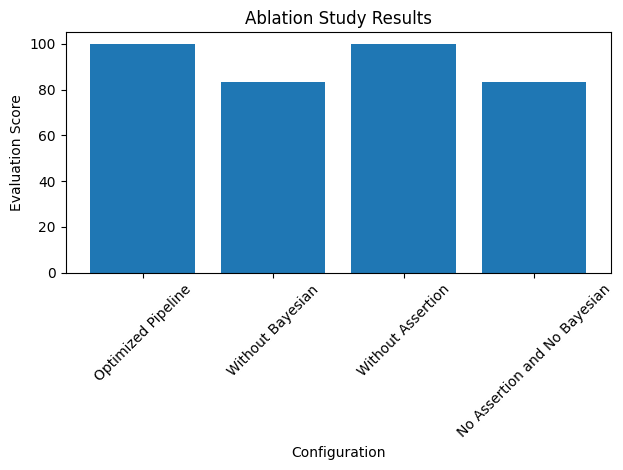

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from dspy.teleprompt import BayesianSignatureOptimizer
from dspy.evaluate.evaluate import Evaluate

allopathic_medicines = ["Paracetamol", "Ibuprofen", "Aspirin", "Omeprazole", "Metformin", "Simvastatin", "Amlodipine", "Levothyroxine", "Lisinopril"]


def should_be_correct(que, rem):
  check=dspy.Predict("question -> answer")
  result=check(question=f"Is this {rem}; a correct remedy for {que}. Return 0 for False and 1 for True.")
  if result.answer==0:
    return False
  else:
    return True



class RemedySuggest(dspy.Signature):
    """Suggest one best home remedy for the provided symptoms (only natural methods)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Suggested home remedy (less than 200 characters)")


class HomeRemedyPipelineAssertions(dspy.Module):
    def __init__(self, assert_on=True):
        super().__init__()
        self.assert_on = assert_on
        self.remedy_suggest = dspy.ChainOfThought(RemedySuggest)

    def forward(self, question, **kwargs):
        suggested_remedy = self.remedy_suggest(question=question)

        if self.assert_on:
            dspy.Suggest(
                should_be_correct(question, suggested_remedy),
                "The suggested remedy should be correct.",
                target_module=RemedySuggest
            )

        return suggested_remedy


class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="Only True or False")


def metric(gold, pred, trace=None):
    question, answer, remedy = gold.question, gold.answer, pred.answer

    correctness = f"The given remedy {remedy} will be effective for this issue {question}. The gold answer is {answer}"
    informative = f"For this issue {question} is the given {remedy} informative. The gold answer is {answer}"

    correct = dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=correctness)
    informative = dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=informative)

    correctness_score = correct.assessment_answer
    info_score = informative.assessment_answer
    score = 0

    if correctness_score == "True":
        score += 1

    if info_score == "True":
        score += 1

    return score / 2.0


# Define your devset and kwargs here
# Replace placeholders with your actual development dataset and any additional keyword arguments you need for evaluation

kwargs = dict(display_progress=True, display_table=5)

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)

# Define function to evaluate pipeline
def evaluate_pipeline(assertion=True, bayesian=True):
    home_remedy = HomeRemedyPipelineAssertions()

    # Compile the pipeline with specified configurations
    if assertion and bayesian:
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(home_remedy, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Optimized Pipeline"
    elif assertion and not bayesian:
        compiled_pipeline = home_remedy
        config_label = "Without Bayesian"
    elif not assertion and bayesian:
        without_assertion=HomeRemedyPipelineAssertions(assert_on=False)
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(without_assertion, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Without Assertion"
    else:
        without_assertion_and_bayesian=HomeRemedyPipelineAssertions(assert_on=False)
        compiled_pipeline = without_assertion_and_bayesian
        config_label = "No Assertion and No Bayesian"

    # Evaluate the compiled pipeline
    eval_score = evaluate_on_hotpotqa(compiled_pipeline, metric=metric)
    return eval_score, config_label


# Run the evaluation for each configuration
scores = []
config_labels = []

for assertion in [True, False]:
    for bayesian in [True, False]:
        eval_score, config_label = evaluate_pipeline(assertion=assertion, bayesian=bayesian)
        scores.append(eval_score)
        config_labels.append(config_label)

# Plotting the results
x = np.arange(len(config_labels))
plt.bar(x, scores)
plt.xlabel('Configuration')
plt.ylabel('Evaluation Score')
plt.title('Ablation Study Results')
plt.xticks(x, config_labels, rotation=45)
plt.tight_layout()
plt.show()


In [58]:
%%writefile HRP.py

#ALL THE IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN
import argparse
from dspy.teleprompt import BayesianSignatureOptimizer

#MODEL
model_name="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ"
lm = dspy.HFClientVLLM(model=model_name, port=8000, url="http://localhost")
dspy.settings.configure(lm=lm)

#DATSETS FOR OPTIMIZERS
train = [
    ('Why does my stomach hurt?', 'Drink chamomile tea and eat ginger biscuits.'),
    ('I have a headache, what should I do?', 'Take a nap and drink plenty of water.'),
    ('My throat is sore, what can I do about it?', 'Gargle with warm salt water and drink honey lemon tea.'),
    ('What should I do for a stuffy nose?', 'Use a saline nasal spray and inhale steam from a bowl of hot water.'),
    ('I feel nauseous, what should I eat?', 'Try eating crackers and sipping on ginger ale.'),
    ('How can I relieve muscle pain?', 'Take a warm bath and apply a heating pad to the affected area.'),
    ('What can I do for a minor burn?', 'Run cool water over the burn and apply aloe vera gel.'),
    ('My back hurts, what can I do to alleviate the pain?', 'Stretch gently and apply a warm compress to your back.'),
    ('I have a splinter, what is the best way to remove it?', 'Soak the affected area in warm, soapy water and carefully use tweezers to remove the splinter.'),
    ('What can I do to calm my nerves?', 'Practice deep breathing exercises and try mindfulness meditation techniques.'),
]


dev = [
    ('How can I get rid of a cold quickly?', 'Drink plenty of fluids and get plenty of rest.'),
    ('What should I do for an upset stomach?', 'Avoid spicy and greasy foods, and drink peppermint tea.'),
    ('I have a minor cut, what is the best way to treat it?', 'Clean the cut with water, and cover it with a bandage.'),
    ('My eyes feel tired and strained, what can I do?', 'Take frequent breaks from screens.'),
    ('What can I do for a bee sting?', 'Remove the stinger if it\'s still in the skin, wash the area with water.'),
    ('How can I relieve sunburn pain?', 'Take a cool bath or shower, drink plenty of water to stay hydrated.'),
    ('I have a minor abrasion, what should I do?', 'Clean the wound with mild soap and water.'),
    ('My tooth is aching, what can I do to ease the pain?', 'Rinse your mouth with warm salt water.'),
    ('How can I alleviate menstrual cramps?', 'Apply a heating pad to your abdomen and take a warm bath.'),
]

# Convert the dataset into DSPy Examples
trainset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in train]
devset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in dev]

# Print the lengths of trainset and devset
print(len(trainset), len(devset))

# Access an example from trainset and devset
train_example = trainset[0]
dev_example = devset[0]
# print(train_example.question)



def should_be_correct(que, rem):
  check=dspy.Predict("question -> answer")
  result=check(question=f"Is this {rem}; a correct remedy for {que}. Return 0 for False and 1 for True.")
  if result.answer==0:
    return False
  else:
    return True

class RemedySuggest(dspy.Signature):
    """Suggest one best home remedy for the provided symptoms (only natural methods)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Suggested home remedy (less than 200 characters)")


class HomeRemedyPipelineAssertions(dspy.Module):
    def __init__(self, assert_on=True):
        super().__init__()
        self.assert_on = assert_on
        self.remedy_suggest = dspy.ChainOfThought(RemedySuggest)

    def forward(self, question, **kwargs):
        suggested_remedy = self.remedy_suggest(question=question)

        if self.assert_on:
            dspy.Suggest(
                should_be_correct(question, suggested_remedy),
                "The suggested remedy should be correct.",
                target_module=RemedySuggest
            )

        return suggested_remedy


class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="Only True or False")


def metric(gold, pred, trace=None):
    question, answer, remedy = gold.question, gold.answer, pred.answer

    correctness = f"The given remedy {remedy} will be effective for this issue {question}. The gold answer is {answer}"
    informative = f"For this issue {question} is the given {remedy} informative. The gold answer is {answer}"

    correct = dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=correctness)
    informative = dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=informative)

    correctness_score = correct.assessment_answer
    info_score = informative.assessment_answer
    score = 0

    if correctness_score == "True":
        score += 1

    if info_score == "True":
        score += 1

    return score / 2.0


# Define your devset and kwargs here
# Replace placeholders with your actual development dataset and any additional keyword arguments you need for evaluation

kwargs = dict(display_progress=True, display_table=5)

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)

# Define function to evaluate pipeline
def evaluate_pipeline(model_name, assertion=True, bayesian=True):
    home_remedy = HomeRemedyPipelineAssertions()

    # Compile the pipeline with specified configurations
    if assertion and bayesian:
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(home_remedy, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Optimized Pipeline"
    elif assertion and not bayesian:
        compiled_pipeline = home_remedy
        config_label = "Without Bayesian"
    elif not assertion and bayesian:
        without_assertion=HomeRemedyPipelineAssertions(assert_on=False)
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(without_assertion, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Without Assertion"
    else:
        without_assertion_and_bayesian=HomeRemedyPipelineAssertions(assert_on=False)
        compiled_pipeline = without_assertion_and_bayesian
        config_label = "No Assertion and No Bayesian"

    # Evaluate the compiled pipeline
    eval_score = evaluate_on_hotpotqa(compiled_pipeline, metric=metric)
    return eval_score, config_label


# Run the evaluation for each configuration
def run_ablation_study(model_name, disable_assertion=False, disable_bayesian=False):
    scores = []
    config_labels = []

    for assertion in [True, False]:
        if disable_assertion and not assertion:
            continue
        for bayesian in [True, False]:
            if disable_bayesian and not bayesian:
                continue
            eval_score, config_label = evaluate_pipeline(model_name, assertion=assertion, bayesian=bayesian)
            scores.append(eval_score)
            config_labels.append(config_label)

    return scores, config_labels

def use_pipeline_as_user(model_name, question):
    home_remedy = HomeRemedyPipelineAssertions()
    result = home_remedy(question=question)
    print("Suggested remedy:", result.answer)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Pipeline for suggesting home remedies.")
    parser.add_argument("--assertion", type=bool, default=True, help="Whether to include assertion in the pipeline. Default: True")
    parser.add_argument("--bayesian", type=bool, default=True, help="Whether to use Bayesian optimization. Default: True")
    parser.add_argument("--run-ablation", action="store_true", help="Perform an ablation study.")
    parser.add_argument("--model-name", type=str, default="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ", help="Name of the language model. Default: TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ")
    parser.add_argument("--user-question", type=str, help="Question to use the pipeline as a user.")
    parser.add_argument("--disable-assertion", action="store_true", help="Disable assertion in the pipeline during ablation study.")
    parser.add_argument("--disable-bayesian", action="store_true", help="Disable Bayesian optimization in the pipeline during ablation study.")
    args = parser.parse_args()

    if args.run_ablation:
        scores, config_labels = run_ablation_study(args.model_name, disable_assertion=args.disable_assertion, disable_bayesian=args.disable_bayesian)
        # Plotting the results
        x = np.arange(len(config_labels))
        plt.bar(x, scores)
        plt.xlabel('Configuration')
        plt.ylabel('Evaluation Score')
        plt.title('Ablation Study Results')
        plt.xticks(x, config_labels, rotation=45)
        plt.tight_layout()
        plt.show()
    elif args.user_question:
        use_pipeline_as_user(args.model_name, args.user_question)
    else:
        eval_score, config_label = evaluate_pipeline(args.model_name, assertion=args.assertion, bayesian=args.bayesian)
        print(f"Evaluation Score: {eval_score}, Configuration: {config_label}")


Overwriting HRP.py


In [55]:
!python HRP.py --user-question "My body aches"

10 9
Suggested remedy: Apply a heating pad or take a warm bath to help soothe your aching muscles.


In [56]:
!python HRP.py --user-question "My chest hurts" --bayesian False

10 9
Suggested remedy: Applying a warm compress on your chest can help soothe the pain. You can also try taking deep breaths and practicing relaxation techniques to help ease the discomfort.


In [57]:
!python HRP.py --run-ablation

10 9
 33% 3/9 [00:00<00:00, 186.68it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
 33% 3/9 [00:00<00:00, 235.16it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
 33% 3/9 [00:00<00:00, 245.07it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
 33% 3/9 [00:00<00:00, 260.85it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
[I 2024-02-16 00:55:45,327] A new study created in memory with name: no-name-442436c7-53ae-41b1-99d1-66228a920bac
Average Metric: 9.0 / 9  (100.0): 100% 9/9 [00:00<00:00, 246.32it/s]
Average Metric: 9.0 / 9  (100.0%)
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Question: ${assessment_question}

Reasoning: Let's think step by step in orde

In [ ]:
remedy="Drink cold water"
question="I have a headache"

class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="Only True or False")


correctness=f"The given remedy {remedy} will be effective for this issue {question}."
informative=f"For this issue{question} the given {remedy} is informative."

correct=dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=correctness)
informative=dspy.ChainOfThought(Assess)(assessed_text=question, assessment_question=informative)


print(correct.assessment_answer)
print(informative.assessment_answer)
print("__________________________________")

# Extract numerical scores only
print(correct.assessment_answer.split(':')[0].strip())
print(informative.assessment_answer.split(':')[0].strip())
correctness_score=correct.assessment_answer
info_score=informative.assessment_answer
score=0
if correctness_score=="True":
  score+=1
if info_score=="True":
  score+=1


print(score)

False
True
__________________________________
False
True
1


In [ ]:
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN

class NER(dspy.Signature):
    """Name entity recognition(Medical related)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Medical name entities")


class MedicalNER(dspy.Module):
    """NER"""

    def __init__(self):
        super().__init__()
        self.remedy_suggest = dspy.ChainOfThought(NER)

    def forward(self, question, **kwargs):
        return self.remedy_suggest(question=question)






In [ ]:
pipeline = MedicalNER()
user_input = [
    "I have a headache and a fever, my thorat also feels choke",
    "My joints ache and I have a rash also i was feeling blue today",
    # Add more user input sentences here
]
for input_sentence in user_input:
    diagnosis = pipeline.forward(input_sentence)
    print(f"Input Sentence: {input_sentence}")
    print(f"Predicted Diagnosis: {diagnosis.answer}")
    print()


Input Sentence: I have a headache and a fever, my thorat also feels choke
Predicted Diagnosis: Headache, fever, and throat discomfort.

Input Sentence: My joints ache and I have a rash also i was feeling blue today
Predicted Diagnosis: Joint ache, rash, depression



In [ ]:
import dspy

class NER(dspy.Signature):
    """Name entity recognition(Medical related)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Medical name entities")

class MedicalNER:
    """NER"""

    def __init__(self):
        self.remedy_suggest = dspy.ChainOfThought(NER)

    def forward(self, question, **kwargs):
        return self.remedy_suggest(question=question)

# Usage
medical_ner = MedicalNER()
result = medical_ner.forward(question="What are the symptoms of COVID-19?")
print("NER result:", result)


NER result: Prediction(
    rationale='identify the symptoms of COVID-19. We can refer to the World Health Organization (WHO) and the Centers for Disease Control and Prevention (CDC) for accurate information. According to the WHO and CDC, the most common symptoms of COVID-19 include fever, dry cough, and tiredness. Other symptoms may include aches and pains, nasal congestion, headache, conjunctivitis, sore throat, and diarrhea.',
    answer='Fever, dry cough, tiredness, aches and pains, nasal congestion, headache, conjunctivitis, sore throat, and diarrhea.'
)


In [ ]:
%%writefile parsing.py
import argparse
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN

class RemedySuggest(dspy.Signature):
    """Suggests home remedy for the provided symptoms(only natural methods)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Suggested home remedy(less than 100 words)")

class HomeRemedyPipeline(dspy.Module):
    """HomeRemedy"""

    def __init__(self):
        super().__init__()
        self.remedy_suggest = dspy.ChainOfThought(RemedySuggest)

    def forward(self, question):
        return self.remedy_suggest(question=question)

if __name__ == "__main__":
    # Initialize argparse
    parser = argparse.ArgumentParser(description='Home Remedy Pipeline')
    parser.add_argument('--question', type=str, help="Patient's input")
    args = parser.parse_args()

    # Create an instance of HomeRemedyPipeline
    home_remedy_pipeline = HomeRemedyPipeline()

    # Call the forward method with the question argument
    result = home_remedy_pipeline.forward(args.question)

    # Print the suggested home remedy
    print("Suggested home remedy:", result.answer)



Overwriting parsing.py


In [ ]:
allopathic_medicines = [
    "Paracetamol",
    "Ibuprofen",
    "Aspirin",
    "Omeprazole",
    "Metformin",
    "Simvastatin",
    "Amlodipine",
    "Levothyroxine",
    "Lisinopril",
    "Atorvastatin",
    "Metoprolol",
    "Losartan",
    "Gabapentin",
    "Amoxicillin",
    "Azithromycin",
    "Ciprofloxacin",
    "Prednisone",
    "Albuterol",
    "Hydrochlorothiazide",
    "Pantoprazole",
    "Warfarin",
    "Fluoxetine",
    "Sertraline",
    "Citalopram",
    "Escitalopram",
    "Tramadol",
    "Codeine",
    "Morphine",
    "Metronidazole",
    "Lorazepam",
    "Diazepam",
    "Acetaminophen",
    "Furosemide",
    "Fluticasone",
    "Ranitidine",
    "Clarithromycin",
    "Cephalexin",
    "Trazodone",
    "Duloxetine",
    "Venlafaxine",
    "Cyclobenzaprine",
    "Hydrocodone",
    "Methylprednisolone",
    "Prednisolone",
    "Levofloxacin",
    "Amoxicillin/clavulanate",
    "Naproxen",
    "Diphenhydramine",
    "Cetirizine",
    "Levothyroxine sodium"
]


In [ ]:
class Pipeline:
    """Pipeline for home remedy suggestions with assertions"""

    class RemedySuggest(dspy.Signature):
        """Suggest one best home remedy for the provided symptoms(only natural methods)"""
        question = dspy.InputField(desc="Patient's input")
        answer = dspy.OutputField(desc="Suggested home remedy(less than 100 words)")

    class HomeRemedyPipelineAssertions(dspy.Module):
      """Pipeline for home remedy suggestions"""
      def __init__(self):
          super().__init__()
          self.remedy_suggest = dspy.ChainOfThought(Pipeline.RemedySuggest)

      def forward(self, question, **kwargs):
          suggested_remedy = self.remedy_suggest(question=question)

          dspy.Assert(
              not any(keyword in suggested_remedy.answer.lower() for keyword in allopathic_medicines),
              "It's recommended to stick to home remedies. Avoid suggesting medicines.",
              target_module=Pipeline.RemedySuggest
          )

          # You can add more assertions or suggestions here

          return suggested_remedy

    class HomeRemedyEvaluator:
      """Evaluate the quality of home remedy suggestions."""

    @staticmethod
    def evaluate_remedy(suggested_remedy):
        # Check if the suggested remedy contains any allopathic medicines
        contains_allopathic = any(keyword in suggested_remedy.lower() for keyword in allopathic_medicines)

        # Check if the remedy is concise (less than 100 words)
        is_concise = len(suggested_remedy.split()) <= 100

        # Check if the remedy is informative (not too brief)
        is_informative = len(suggested_remedy) >= 50

        # Evaluate overall quality based on criteria
        quality = not contains_allopathic and is_concise and is_informative

        return quality

    def __init__(self):
      self.home_remedy_pipeline = self.HomeRemedyPipelineAssertions()

    def process(self, question):
      return self.home_remedy_pipeline.forward(question=question)

# Usage
pipeline = Pipeline()
result = pipeline.process(question="What is a treatment for influenza?")
print("Suggested remedy:", result.answer)


Suggested remedy: To treat influenza, you can try the following home remedy:

1. Drink plenty of fluids, such as water, herbal tea, or warm lemon water, to stay hydrated and help flush out toxins.
2. Get plenty of rest to give your immune system the energy it needs to fight off the virus.
3. Eat nutritious foods, such as fruits, vegetables, and lean proteins, to provide your body with the necessary vitamins and minerals.
4. Consider taking natural supplements, such as vitamin C


In [ ]:
class HomeRemedyEvaluator:
        """Evaluate the quality of home remedy suggestions."""

        class Assess(dspy.Signature):
          """Answer Correctness"""
          input = dspy.InputField(desc="patient's input")
          remedy = dspy.InputField(desc="suggested home remedy")
          score = dspy.OutputField(desc="correctness score(range 0 to 1)")

        with dspy.context(lm=lm):
          @staticmethod
          def metric(input, remedy):
            score = dspy.Predict(HomeRemedyEvaluator.Assess)(input=input, remedy=remedy)
            return score


# Usage example:
suggested_remedy = result.answer
is_quality = HomeRemedyEvaluator.metric("What is a treatment for influenza?", remedy=suggested_remedy)
print("Is the suggested remedy of good quality?", is_quality)


Is the suggested remedy of good quality? Prediction(
    score='0.95'
)


In [ ]:

train = [
    ('Why does my stomach hurt?', 'Drink chamomile tea and eat ginger biscuits.'),
    ('I have a headache, what should I do?', 'Take a nap and drink plenty of water.'),
    ('My throat is sore, what can I do about it?', 'Gargle with warm salt water and drink honey lemon tea.'),
    ('What should I do for a stuffy nose?', 'Use a saline nasal spray and inhale steam from a bowl of hot water.'),
    ('I feel nauseous, what should I eat?', 'Try eating crackers and sipping on ginger ale.'),
    ('How can I relieve muscle pain?', 'Take a warm bath with Epsom salts and apply a heating pad to the affected area.'),
    ('What can I do for a minor burn?', 'Run cool water over the burn and apply aloe vera gel.'),
    ('My back hurts, what can I do to alleviate the pain?', 'Stretch gently and apply a warm compress to your back.'),
    ('I have a splinter, what is the best way to remove it?', 'Soak the affected area in warm, soapy water and carefully use tweezers to remove the splinter.'),
    ('What can I do to calm my nerves?', 'Practice deep breathing exercises and try mindfulness meditation techniques.'),
]


dev = [
    ('How can I get rid of a cold quickly?', 'Drink plenty of fluids and get plenty of rest.'),
    ('What should I do for an upset stomach?', 'Avoid spicy and greasy foods, and drink peppermint tea.'),
    ('I have a minor cut, what is the best way to treat it?', 'Clean the cut with soap and water, apply an antibiotic ointment, and cover it with a bandage.'),
    ('My eyes feel tired and strained, what can I do?', 'Take frequent breaks from screens and try using lubricating eye drops.'),
    ('What can I do for a bee sting?', 'Remove the stinger if it\'s still in the skin, wash the area with soap and water, and apply a cold compress.'),
    ('How can I relieve sunburn pain?', 'Take a cool bath or shower, apply aloe vera gel, and drink plenty of water to stay hydrated.'),
    ('I have a minor abrasion, what should I do?', 'Clean the wound with mild soap and water, apply an antibiotic ointment, and cover it with a sterile bandage.'),
    ('My tooth is aching, what can I do to ease the pain?', 'Rinse your mouth with warm salt water and use an over-the-counter pain reliever like ibuprofen.'),
    ('How can I alleviate menstrual cramps?', 'Apply a heating pad to your abdomen and take a warm bath.'),
]

# Convert the dataset into DSPy Examples
# Convert the dataset into DSPy Examples
trainset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in train]
devset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in dev]

# Print the lengths of trainset and devset
print(len(trainset), len(devset))


# Print the lengths of trainset and devset
print(len(trainset), len(devset))

# Access an example from trainset and devset
train_example = trainset[0]
dev_example = devset[0]


print(train_example.question)

10 9
10 9
Why does my stomach hurt?


In [ ]:
class Assess(dspy.Signature):
  """Answer Correctness"""
  input = dspy.InputField(desc="patient's input")
  remedy = dspy.InputField(desc="suggested home remedy")
  score = dspy.OutputField(desc="correctness score(range 0 to 1)")

def metric(input, remedy):
  score = dspy.Predict(Assess)(input=input, remedy=remedy)
  return score

In [ ]:
!pip install faiss-cpu
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN

knn_teleprompter = KNNFewShot(KNN, 7, trainset)
compiled_knn = knn_teleprompter.compile(Pipeline(), trainset=trainset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

AttributeError: 'Pipeline' object has no attribute 'reset_copy'

In [ ]:
%%writefile parsing.py
import argparse
import dspy
import sys

lm = dspy.HFClientVLLM(model="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ", port=8000, url="http://localhost")

dspy.settings.configure(lm=lm)
allopathic_medicines = [
    "Paracetamol",
    "Ibuprofen",
    "Aspirin",
    "Omeprazole",
    "Metformin",
    "Simvastatin",
    "Amlodipine",
    "Levothyroxine",
    "Lisinopril",
    "Atorvastatin",
    "Metoprolol",
    "Losartan",
    "Gabapentin",
    "Amoxicillin",
    "Azithromycin",
    "Ciprofloxacin",
    "Prednisone",
    "Albuterol",
    "Hydrochlorothiazide",
    "Pantoprazole",
    "Warfarin",
    "Fluoxetine",
    "Sertraline",
    "Citalopram",
    "Escitalopram",
    "Tramadol",
    "Codeine",
    "Morphine",
    "Metronidazole",
    "Lorazepam",
    "Diazepam",
    "Acetaminophen",
    "Furosemide",
    "Fluticasone",
    "Ranitidine",
    "Clarithromycin",
    "Cephalexin",
    "Trazodone",
    "Duloxetine",
    "Venlafaxine",
    "Cyclobenzaprine",
    "Hydrocodone",
    "Methylprednisolone",
    "Prednisolone",
    "Levofloxacin",
    "Amoxicillin/clavulanate",
    "Naproxen",
    "Diphenhydramine",
    "Cetirizine",
    "Levothyroxine sodium"
]



class Pipeline:
    """Pipeline for home remedy suggestions with assertions"""

    class RemedySuggest(dspy.Signature):
        """Suggest one best home remedy for the provided symptoms (only natural methods)"""
        question = dspy.InputField(desc="Patient's input")
        answer = dspy.OutputField(desc="Suggested home remedy (less than 100 words)")

    class HomeRemedyPipelineAssertions(dspy.Module):
        """Pipeline for home remedy suggestions"""

        def __init__(self):
            super().__init__()
            self.remedy_suggest = dspy.ChainOfThought(Pipeline.RemedySuggest)

        def forward(self, question, **kwargs):
            suggested_remedy = self.remedy_suggest(question=question)

            # Add assertions or suggestions here
            dspy.Assert(
                not any(keyword in suggested_remedy.answer.lower() for keyword in allopathic_medicines),
                "It's recommended to stick to home remedies. Avoid suggesting medicines.",
                target_module=Pipeline.RemedySuggest
            )

            return suggested_remedy

    def __init__(self, model_name):
        self.home_remedy_pipeline = self.HomeRemedyPipelineAssertions()
        self.model_name = model_name

    def process(self, question):
        return self.home_remedy_pipeline.forward(question=question)

def main():
    parser = argparse.ArgumentParser(description="Home Remedy Pipeline with Assertions")
    parser.add_argument("model_name", required=True, type=str, help="Name of the model")
    parser.add_argument("--question", type=str, required=True, help="Patient's input question")
    args = parser.parse_args()

    pipeline = Pipeline(model_name=args.model_name)
    result = pipeline.process(question=args.question)
    print("Suggested remedy:", result.answer)

if __name__ == "__main__":
    main()



Overwriting parsing.py


In [ ]:
!python parsing.py --question "What is a natural remedy for white hair?"

Traceback (most recent call last):
  File "/content/parsing.py", line 108, in <module>
    main()
  File "/content/parsing.py", line 99, in main
    parser.add_argument("model_name", required=True, type=str, help="Name of the model")
  File "/usr/lib/python3.10/argparse.py", line 1424, in add_argument
    kwargs = self._get_positional_kwargs(*args, **kwargs)
  File "/usr/lib/python3.10/argparse.py", line 1540, in _get_positional_kwargs
    raise TypeError(msg)
TypeError: 'required' is an invalid argument for positionals


In [ ]:

import argparse

class Pipeline:
    """Pipeline for home remedy suggestions with assertions"""

    class RemedySuggest(dspy.Signature):
        """Suggest one best home remedy for the provided symptoms(only natural methods)"""
        question = dspy.InputField(desc="Patient's input")
        answer = dspy.OutputField(desc="Suggested home remedy(less than 100 words)")

    class HomeRemedyPipelineAssertions(dspy.Module):
        """Pipeline for home remedy suggestions"""
        def __init__(self, enable_assertions=True, enable_bootstrap_fewshot=True, enable_knn_fewshot=True):
            super().__init__()
            self.enable_assertions = enable_assertions
            self.enable_bootstrap_fewshot = enable_bootstrap_fewshot
            self.enable_knn_fewshot = enable_knn_fewshot
            self.remedy_suggest = dspy.ChainOfThought(Pipeline.RemedySuggest)

            # Initialize BootstrapFewShot and KNNFewShot modules
            if self.enable_bootstrap_fewshot:
                self.bootstrap_fewshot = BootstrapFewShot()
            if self.enable_knn_fewshot:
                self.knn_fewshot = KNNFewShot()

        def forward(self, question, **kwargs):
            suggested_remedy = self.remedy_suggest(question=question)

            # Assertion checks
            if self.enable_assertions:
                dspy.Assert(
                    not any(keyword in suggested_remedy.answer.lower() for keyword in allopathic_medicines),
                    "It's recommended to stick to home remedies. Avoid suggesting medicines.",
                    target_module=Pipeline.RemedySuggest
                )

                # You can add more assertions or suggestions here

            # BootstrapFewShot
            if self.enable_bootstrap_fewshot:
              metric = dspy.evaluate.answer_exact_match
              teleprompter = BootstrapFewShot(metric=metric)
              compiled_bs = teleprompter.compile(student=HomeRemedyPipeline(), trainset=trainset)

                # Apply BootstrapFewShot logic

            # KNNFewShot
            if self.enable_knn_fewshot:
              pass
                # Apply KNNFewShot logic

            return suggested_remedy

    class HomeRemedyEvaluator:
      """Evaluate the quality of home remedy suggestions."""
    @staticmethod
    def evaluate_remedy(suggested_remedy):


        # Check if the suggested remedy contains any allopathic medicines
        contains_allopathic = any(keyword in suggested_remedy.lower() for keyword in allopathic_medicines)

        # Check if the remedy is concise (less than 100 words)
        is_concise = len(suggested_remedy.split()) <= 100

        # Check if the remedy is informative (not too brief)
        is_informative = len(suggested_remedy) >= 50

        # Evaluate overall quality based on criteria
        quality = not contains_allopathic and is_concise and is_informative

        return quality


##
    def __init__(self, enable_assertions=True, enable_bootstrap_fewshot=True, enable_knn_fewshot=True):
        self.home_remedy_pipeline = self.HomeRemedyPipelineAssertions(
            enable_assertions=enable_assertions,
            enable_bootstrap_fewshot=enable_bootstrap_fewshot,
            enable_knn_fewshot=enable_knn_fewshot
        )

    def process(self, question):
        return self.home_remedy_pipeline.forward(question=question),

if __name__ == "__main__":
    # Create argument parser
    parser = argparse.ArgumentParser(description="Home Remedy Pipeline")

    # Add arguments
    parser.add_argument("model_name", type=str, help="Name of the model to use")
    parser.add_argument("question", type=str, help="Patient's input question")
    parser.add_argument("--disable-assertions", action="store_false", help="Disable assertion checks")
    parser.add_argument("--disable-bootstrap-fewshot", action="store_false", help="Disable BootstrapFewShot")
    parser.add_argument("--disable-knn-fewshot", action="store_false", help="Disable KNNFewShot")

    # Parse arguments
    args = parser.parse_args()

    # Process pipeline
    pipeline = Pipeline(
        enable_assertions=args.disable_assertions,
        enable_bootstrap_fewshot=args.disable_bootstrap_fewshot,
        enable_knn_fewshot=args.disable_knn_fewshot
    )
    result = pipeline.process(question=args.question)
    print("Suggested remedy:", result.answer)


Writing parsing.py


In [ ]:
#%%writefile parsing.py
import argparse
import dspy

lm = dspy.HFClientVLLM(model="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ", port=8000, url="http://localhost")

dspy.settings.configure(lm=lm)
allopathic_medicines = [
    "Paracetamol",
    "Ibuprofen",
    "Aspirin",
    "Omeprazole",
    "Metformin",
    "Simvastatin",
    "Amlodipine",
    "Levothyroxine",
    "Lisinopril",
    "Atorvastatin",
    "Metoprolol",
    "Losartan",
    "Gabapentin",
    "Amoxicillin",
    "Azithromycin",
    "Ciprofloxacin",
    "Prednisone",
    "Albuterol",
    "Hydrochlorothiazide",
    "Pantoprazole",
    "Warfarin",
    "Fluoxetine",
    "Sertraline",
    "Citalopram",
    "Escitalopram",
    "Tramadol",
    "Codeine",
    "Morphine",
    "Metronidazole",
    "Lorazepam",
    "Diazepam",
    "Acetaminophen",
    "Furosemide",
    "Fluticasone",
    "Ranitidine",
    "Clarithromycin",
    "Cephalexin",
    "Trazodone",
    "Duloxetine",
    "Venlafaxine",
    "Cyclobenzaprine",
    "Hydrocodone",
    "Methylprednisolone",
    "Prednisolone",
    "Levofloxacin",
    "Amoxicillin/clavulanate",
    "Naproxen",
    "Diphenhydramine",
    "Cetirizine",
    "Levothyroxine sodium"
]



class Pipeline:
    """Pipeline for home remedy suggestions with assertions"""

    class RemedySuggest(dspy.Signature):
        """Suggest best home remedy for the provided symptoms(only natural methods)"""
        question = dspy.InputField(desc="Patient's input")
        answer = dspy.OutputField(desc="Suggested home remedy(less than 100 words)")

    class HomeRemedyPipelineAssertions(dspy.Module):
      """Pipeline for home remedy suggestions"""
      def __init__(self):
          super().__init__()
          self.remedy_suggest = dspy.ChainOfThought(Pipeline.RemedySuggest)

      def forward(self, question, **kwargs):
          suggested_remedy = self.remedy_suggest(question=question)

          dspy.Assert(
              not any(keyword in suggested_remedy.answer.lower() for keyword in allopathic_medicines),
              "It's recommended to stick to home remedies. Avoid suggesting medicines.",
              target_module=Pipeline.RemedySuggest
          )

          # Evaluate the quality of the suggested remedy
          is_quality = HomeRemedyEvaluator.evaluate_remedy(suggested_remedy.answer)

          return suggested_remedy, is_quality

    def __init__(self):
      self.home_remedy_pipeline = self.HomeRemedyPipelineAssertions()

    def process(self, question):
      return self.home_remedy_pipeline.forward(question=question)





class HomeRemedyEvaluator:
    """Evaluate the quality of home remedy suggestions."""

    @staticmethod
    def evaluate_remedy(suggested_remedy):
        """
        Evaluate the quality of a suggested home remedy.

        Args:
            suggested_remedy (str): The suggested home remedy.

        Returns:
            bool: True if the remedy meets the quality criteria, False otherwise.
        """
        # Check if the suggested remedy contains any allopathic medicines
        allopathic_medicines = ["aspirin", "ibuprofen", "acetaminophen", "paracetamol", "antibiotics"]
        contains_allopathic = any(keyword in suggested_remedy.lower() for keyword in allopathic_medicines)

        # Check if the remedy is concise (less than 100 words)
        is_concise = len(suggested_remedy.split()) <= 100

        # Check if the remedy is informative (not too brief)
        is_informative = len(suggested_remedy) >= 50

        # Evaluate overall quality based on criteria
        quality = not contains_allopathic and is_concise and is_informative

        return quality

# Create CLI interface
def parse_args():
    parser = argparse.ArgumentParser(description="Home Remedy Pipeline")
    parser.add_argument("--question", type=str, required=True, help="Patient's input question")
    return parser.parse_args()

# Main function
def main():
    args = parse_args()
    pipeline = Pipeline()
    suggested_remedy, is_quality = pipeline.process(question=args.question)
    print("Suggested remedy:", suggested_remedy.answer)
    print("Is the suggested remedy of good quality?", is_quality)

if __name__ == "__main__":
    main()


Overwriting parsing.py


In [ ]:
!python parsing.py --question "What is a natural remedy for blue hair?"

Suggested remedy: To remove blue hair color naturally, mix equal parts of lemon juice and baking soda to create a paste. Apply this paste to your hair and let it sit for 15-20 minutes. Afterward, rinse your hair with warm water and then wash it with a gentle shampoo. Finally, apply apple cider vinegar to your hair as a rinse to help seal in the color and remove any remaining blue tones.
Is the suggested remedy of good quality? True


In [ ]:
import argparse
import dspy

class Pipeline:
    """Pipeline for home remedy suggestions with assertions"""

    class RemedySuggest(dspy.Signature):
        """Suggest one best home remedy for the provided symptoms(only natural methods)"""
        question = dspy.InputField(desc="Patient's input")
        answer = dspy.OutputField(desc="Suggested home remedy(less than 100 words)")

    class HomeRemedyPipelineAssertions(dspy.Module):
        """Pipeline for home remedy suggestions"""
        def __init__(self, enable_assertions=True, enable_bootstrap_fewshot=True, enable_knn_fewshot=True):
            super().__init__()
            self.enable_assertions = enable_assertions
            self.enable_bootstrap_fewshot = enable_bootstrap_fewshot
            self.enable_knn_fewshot = enable_knn_fewshot
            self.remedy_suggest = dspy.ChainOfThought(Pipeline.RemedySuggest)

            # Initialize BootstrapFewShot and KNNFewShot modules
            if self.enable_bootstrap_fewshot:
                self.bootstrap_fewshot = BootstrapFewShot()
            if self.enable_knn_fewshot:
                self.knn_fewshot = KNNFewShot()

            # Initialize HomeRemedyEvaluator
            self.evaluator = Pipeline.HomeRemedyEvaluator()

        def forward(self, question, **kwargs):
            suggested_remedy = self.remedy_suggest(question=question)

            # Pass the suggested remedy through the evaluator to check against the metric
            metric_score = self.evaluator.evaluate_remedy(question, suggested_remedy.answer)

            # Assertion checks
            if self.enable_assertions:
                dspy.Assert(
                    not any(keyword in suggested_remedy.answer.lower() for keyword in allopathic_medicines),
                    "It's recommended to stick to home remedies. Avoid suggesting medicines.",
                    target_module=Pipeline.RemedySuggest
                )

                # You can add more assertions or suggestions here

            # BootstrapFewShot
            if self.enable_bootstrap_fewshot:
                metric = dspy.evaluate.answer_exact_match
                teleprompter = BootstrapFewShot(metric=metric)
                compiled_bs = teleprompter.compile(student=HomeRemedyPipeline(), trainset=trainset)

                # Apply BootstrapFewShot logic

            # KNNFewShot
            if self.enable_knn_fewshot:
              knn_teleprompter = KNNFewShot(KNN, 3, trainset)
              compiled_knn = knn_teleprompter.compile(HomeRemedyPipeline(), trainset=trainset)

                # Apply KNNFewShot logic

            return suggested_remedy, metric_score

    class HomeRemedyEvaluator:
        """Evaluate the quality of home remedy suggestions."""

        class Assess(dspy.Signature):
          """Answer Correctness"""
          input = dspy.InputField(desc="patient's input")
          remedy = dspy.InputField(desc="suggested home remedy")
          score = dspy.OutputField(desc="correctness score(range 0 to 1)")

        with dspy.context(lm=lm):
          @staticmethod
          def evaluate_remedy(input, remedy):
            score = dspy.Predict(HomeRemedyEvaluator.Assess)(input=input, remedy=remedy)
            return score

    def __init__(self, enable_assertions=True, enable_bootstrap_fewshot=True, enable_knn_fewshot=True):
        self.home_remedy_pipeline = self.HomeRemedyPipelineAssertions(
            enable_assertions=enable_assertions,
            enable_bootstrap_fewshot=enable_bootstrap_fewshot,
            enable_knn_fewshot=enable_knn_fewshot
        )

    def process(self, question):
        return self.home_remedy_pipeline.forward(question=question)

if __name__ == "__main__":
    # Create argument parser
    parser = argparse.ArgumentParser(description="Home Remedy Pipeline")

    # Add arguments
    parser.add_argument("model_name", type=str, help="Name of the model to use")
    parser.add_argument("--question", type=str, help="Patient's input question")
    parser.add_argument("--disable-assertions", action="store_true", help="Disable assertion checks")
    parser.add_argument("--disable-bootstrap-fewshot", action="store_true", help="Disable BootstrapFewShot")
    parser.add_argument("--disable-knn-fewshot", action="store_true", help="Disable KNNFewShot")

    # Parse arguments
    args = parser.parse_args()

    # Process pipeline
    pipeline = Pipeline(
        enable_assertions=not args.disable_assertions,
        enable_bootstrap_fewshot=not args.disable_bootstrap_fewshot,
        enable_knn_fewshot=not args.disable_knn_fewshot
    )
    result = pipeline.process(question=args.question)
    print("Suggested remedy:", result.answer)


    # Parse arguments
    args = parser.parse_args()

    # Process pipeline
    pipeline = Pipeline(
        enable_assertions=args.disable_assertions,
        enable_bootstrap_fewshot=args.disable_bootstrap_fewshot,
        enable_knn_fewshot=args.disable_knn_fewshot
    )
    result, metric_score = pipeline.process(question=args.question)
    print("Suggested remedy:", result.answer)
    print("Metric Score:", metric_score)


usage: colab_kernel_launcher.py [-h] [--question QUESTION] [--disable-assertions]
                                [--disable-bootstrap-fewshot] [--disable-knn-fewshot]
                                model_name
colab_kernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
!python parsing.py model_name "What is a natural remedy for blue hair?" [--disable-assertions] [--disable-bootstrap-fewshot] [--disable-knn-fewshot]

usage: parsing.py [-h] [--question QUESTION] [--disable-assertions] [--disable-bootstrap-fewshot]
                  [--disable-knn-fewshot]
                  model_name
parsing.py: error: unrecognized arguments: What is a natural remedy for blue hair? [--disable-assertions] [--disable-bootstrap-fewshot] [--disable-knn-fewshot]


In [ ]:
!pip install faiss-cpu sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 19.5 MB/s eta 0:00:00


In [ ]:
#ALL THE IMPORTS
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN
import argparse

#MODEL
model_name="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ"
lm = dspy.HFClientVLLM(model=model_name, port=8000, url="http://localhost")
dspy.settings.configure(lm=lm)

#DATSETS FOR OPTIMIZERS
train = [
    ('Why does my stomach hurt?', 'Drink chamomile tea and eat ginger biscuits.'),
    ('I have a headache, what should I do?', 'Take a nap and drink plenty of water.'),
    ('My throat is sore, what can I do about it?', 'Gargle with warm salt water and drink honey lemon tea.'),
    ('What should I do for a stuffy nose?', 'Inhale steam from a bowl of hot water.'),
    ('I feel nauseous, what should I eat?', 'Try eating crackers and sipping on ginger ale.'),
    ('How can I relieve muscle pain?', 'Take a warm bath with Epsom salts and apply a heating pad to the affected area.'),
    ('What can I do for a minor burn?', 'Run cool water over the burn and apply aloe vera gel.'),
    ('My back hurts, what can I do to alleviate the pain?', 'Stretch gently and apply a warm compress to your back.'),
    ('I have a splinter, what is the best way to remove it?', 'Soak the affected area in warm, soapy water and carefully use tweezers to remove the splinter.'),
    ('What can I do to calm my nerves?', 'Practice deep breathing exercises and try mindfulness meditation techniques.'),
]


dev = [
    ('How can I get rid of a cold quickly?', 'Drink plenty of fluids and get plenty of rest.'),
    ('What should I do for an upset stomach?', 'Avoid spicy and greasy foods, and drink peppermint tea.'),
    ('I have a minor cut, what is the best way to treat it?', 'Clean the cut with soap and water, apply an antibiotic ointment, and cover it with a bandage.'),
    ('My eyes feel tired and strained, what can I do?', 'Take frequent breaks from screens and try using lubricating eye drops.'),
    ('What can I do for a bee sting?', 'Remove the stinger if it\'s still in the skin, wash the area with soap and water, and apply a cold compress.'),
    ('How can I relieve sunburn pain?', 'Take a cool bath or shower, apply aloe vera gel, and drink plenty of water to stay hydrated.'),
    ('I have a minor abrasion, what should I do?', 'Clean the wound with mild soap and water, apply an antibiotic ointment, and cover it with a sterile bandage.'),
    ('My tooth is aching, what can I do to ease the pain?', 'Rinse your mouth with warm salt water and use an over-the-counter pain reliever like ibuprofen.'),
    ('How can I alleviate menstrual cramps?', 'Apply a heating pad to your abdomen and take a warm bath.'),
]

# Convert the dataset into DSPy Examples
trainset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in train]
devset = [dspy.Example(question=question, answer=answer).with_inputs('question') for question, answer in dev]

# Print the lengths of trainset and devset
print(len(trainset), len(devset))

# Access an example from trainset and devset
train_example = trainset[0]
dev_example = devset[0]
# print(train_example.question)


#MAIN PIPELINE
class RemedySuggest(dspy.Signature):
    """Suggest one best home remedy for the provided symptoms (only natural methods)"""
    question = dspy.InputField(desc="Patient's input")
    answer = dspy.OutputField(desc="Suggested home remedy (less than 200 characters)")


class HomeRemedyPipelineAssertions(dspy.Module):
    def __init__(self):
        super().__init__()
        self.remedy_suggest = dspy.ChainOfThought(RemedySuggest)

    def forward(self, question, **kwargs):
        suggested_remedy = self.remedy_suggest(question=question)

        dspy.Assert(
            not any(keyword in suggested_remedy.answer.lower() for keyword in allopathic_medicines),
            "It's recommended to stick to home remedies. Avoid suggesting medicines.",
            target_module=RemedySuggest
        )

        return suggested_remedy

def metric(gold, pred, )


class Pipeline:
    def __init__(self, trainset, devset):
        self.trainset = trainset
        self.devset = devset
        self.assertions = HomeRemedyPipelineAssertions()
        self.knn = KNN(self.trainset)

    def process(self, question):
        return self.assertions.forward(question)


# Create pipeline
pipeline = Pipeline(trainset, devset)
result = pipeline.process(question="What is a natural remedy for blue hair?")
print("Suggested remedy:", result.answer)

10 9


TypeError: 'KNN' object is not callable

In [ ]:
# %%writefile parse.py
import argparse
import csv
from dspy.datasets import HotPotQA
#ALL THE IMPORTS
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN
import argparse

#MODEL
model_name="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ"
lm = dspy.HFClientVLLM(model=model_name, port=8000, url="http://localhost")
dspy.settings.configure(lm=lm)

# Define the BasicQA class and BasicQABot
class BasicQA(dspy.Signature):
    """Answer questions with short factoid answers."""
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

class BasicQABot(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate = dspy.Predict(BasicQA)

    def forward(self, question):
        prediction = self.generate(question=question)
        return dspy.Prediction(answer=prediction.answer)

# Function to load dataset
def load_dataset(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0):
    # Validate dataset sizes
    if train_size <= 0 or dev_size <= 0 or test_size < 0:
        raise ValueError("Dataset sizes must be positive integers.")

    dataset = HotPotQA(train_seed=train_seed, train_size=train_size,
                       eval_seed=eval_seed, dev_size=dev_size, test_size=test_size)
    trainset = [x.with_inputs('question') for x in dataset.train]
    devset = [x.with_inputs('question') for x in dataset.dev]
    return trainset, devset

# Function to compile KNN teleprompter
def compile_knn_teleprompter(trainset):
    knn_teleprompter = dspy.teleprompt.KNNFewShot(KNN, 7, trainset)
    return knn_teleprompter.compile(BasicQABot(), trainset=trainset)

# Function to compile BootstrapFewShot teleprompter
def compile_bootstrap_teleprompter(trainset):
    bootstrap_teleprompter = dspy.teleprompt.BootstrapFewShot(trainset)
    return bootstrap_teleprompter.compile(BasicQABot(), trainset=trainset)

# Function to tune the prompt using an external CSV file
def tune_prompt_from_csv(csv_file):

    pass

# Function to run ablation study
def run_ablation_study(trainset, devset):
    results = {}

    # Original pipeline
    original_pipeline = compile_knn_teleprompter(trainset)
    original_acc = original_pipeline.evaluate(devset)
    results["Original"] = original_acc

    # Ablation study: Switching off elements one by one
    # For example, switch off KNNFewShot
    # knn_off_pipeline = compile_bootstrap_teleprompter(trainset)
    # knn_off_acc = knn_off_pipeline.evaluate(devset)
    # results["KNN Off"] = knn_off_acc

    # Add more ablation study cases as needed

    return results

def main(args):
    # Load dataset
    trainset, devset = load_dataset(args.train_seed, args.train_size, args.eval_seed, args.dev_size, args.test_size)

    # Run ablation study if requested
    if args.ablation_study:
        ablation_results = run_ablation_study(trainset, devset)
        print("Ablation Study Results:")
        for case, acc in ablation_results.items():
            print(f"{case}: {acc}")
    else:
        # Compile teleprompter based on method
        if args.method == "knn":
            compiled_teleprompter = compile_knn_teleprompter(trainset)
        elif args.method == "bootstrap":
            compiled_teleprompter = compile_bootstrap_teleprompter(trainset)
        else:
            raise ValueError("Invalid method. Choose 'knn' or 'bootstrap'.")

        # Tune prompt using external CSV file if provided
        if args.csv_file:
            tune_prompt_from_csv(args.csv_file)

        # Evaluate the compiled teleprompter
        accuracy = compiled_teleprompter.evaluate(devset)
        print(f"Accuracy: {accuracy}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Basic Q&A Pipeline")
    parser.add_argument("--train_seed", type=int, default=1, help="Seed for training data")
    parser.add_argument("--train_size", type=int, default=20, help="Size of the training data")
    parser.add_argument("--eval_seed", type=int, default=2023, help="Seed for evaluation data")
    parser.add_argument("--dev_size", type=int, default=50, help="Size of the development data")
    parser.add_argument("--test_size", type=int, default=0, help="Size of the test data")
    parser.add_argument("--method", type=str, default="knn", choices=["knn", "bootstrap"], help="Few-shot method to use")
    parser.add_argument("--csv_file", type=str, help="Path to CSV file for prompt tuning")
    parser.add_argument("--ablation_study", action="store_true", help="Run ablation study")
    args = parser.parse_args()

    # Validate parameters
    if args.test_size > 0 and args.dev_size == 0:
        raise ValueError("Cannot have test data without development data.")

    main(args)


Overwriting parse.py


In [ ]:
!python parse.py

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Batches: 100% 1/1 [00:00<00:00,  1.58it/s]
Traceback (most recent call last):
  File "/content/parse.py", line 121, in <module>
    main(args)
  File "/content/parse.py", line 102, in main
    accuracy = compiled_teleprompter.evaluate(devset)
AttributeError: 'BasicQABot' object has no attribute 'evaluate'


In [ ]:
import matplotlib.pyplot as plt
from dspy.datasets import HotPotQA


#load dataset
def load_dataset(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0):
    # Validate dataset sizes
    if train_size <= 0 or dev_size <= 0 or test_size < 0:
        raise ValueError("Dataset sizes must be positive integers.")

    dataset = HotPotQA(train_seed=train_seed, train_size=train_size,
                       eval_seed=eval_seed, dev_size=dev_size, test_size=test_size)
    trainset = [x.with_inputs('question') for x in dataset.train]
    devset = [x.with_inputs('question') for x in dataset.dev]
    return trainset, devset

# Define the BasicQA class and BasicQABot
class BasicQA(dspy.Signature):
    """Answer questions with short factoid answers."""
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

class BasicQABot(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate = dspy.Predict(BasicQA)

    def forward(self, question):
        prediction = self.generate(question=question)
        return dspy.Prediction(answer=prediction.answer)

# Function to compile KNN teleprompter
def compile_knn_teleprompter(trainset):
    knn_teleprompter = dspy.teleprompt.KNNFewShot(KNN, 7, trainset)
    return knn_teleprompter.compile(BasicQABot(), trainset=trainset)

# Function to compile BootstrapFewShot teleprompter
def compile_bootstrap_teleprompter(trainset):
    bootstrap_teleprompter = dspy.teleprompt.BootstrapFewShot(metric=metric)
    return bootstrap_teleprompter.compile(BasicQABot(), trainset=trainset)

evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)

# Evaluate the `compiled_rag` program with the `answer_exact_match` metric.
metric = dspy.evaluate.answer_exact_match

# Function to run ablation
def run_ablation_study_plot(trainset, devset):
    results = {}

    # Original pipeline
    original_pipeline = compile_knn_teleprompter(trainset)
    original_acc = evaluate_on_hotpotqa(original_pipeline, metric=metric)
    results["Original"] = original_acc

    # Ablation study: Switching off elements one by one
    bootstrap_pipeline = compile_bootstrap_teleprompter(trainset)
    bootstrap_acc = evaluate_on_hotpotqa(bootstrap_pipeline, metric=metric)
    results["Bootstrap"] = bootstrap_acc

    knn_pipeline = compile_knn_teleprompter(trainset)
    knn_acc = evaluate_on_hotpotqa(knn_pipeline, metric=metric)
    results["KNN"] = knn_acc

    # Both teleprompters
    both_pipeline = compile_knn_teleprompter(trainset)
    both_pipeline.add_teleprompter(compile_bootstrap_teleprompter(trainset))
    both_acc = evaluate_on_hotpotqa(both_pipeline, metric=metric)
    results["Both"] = both_acc

    # Plot results
    plt.bar(results.keys(), results.values())
    plt.ylabel('Accuracy')
    plt.title('Ablation Study Results')
    plt.show()

# Main function
def main(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0, method="knn", csv_file=None, ablation_study=False, disable_teleprompter=False, question=None):
    # Load dataset
    trainset, devset = load_dataset(train_seed, train_size, eval_seed, dev_size, test_size)

    # Run ablation study if requested and plot results
    if ablation_study:
        run_ablation_study_plot(trainset, devset)

# Define parameters
train_seed = 1
train_size = 20
eval_seed = 2023
dev_size = 50
test_size = 0
method = "knn"
csv_file = None
ablation_study = True
disable_teleprompter = False
question = "What is the capital of France?"

# Call main function
main(train_seed, train_size, eval_seed, dev_size, test_size, method, csv_file, ablation_study, disable_teleprompter, question)


Average Metric: 0 / 1  (0.0):   0%|          | 0/50 [00:00<?, ?it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 0 / 2  (0.0):   4%|▍         | 2/50 [00:00<00:03, 15.98it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 0 / 3  (0.0):   4%|▍         | 2/50 [00:00<00:03, 15.98it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 0 / 4  (0.0):   8%|▊         | 4/50 [00:00<00:03, 14.92it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



 57%|█████▋    | 4/7 [00:00<00:00, 438.83it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 0 / 6  (0.0):  12%|█▏        | 6/50 [00:00<00:02, 15.77it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 0 / 7  (0.0):  12%|█▏        | 6/50 [00:00<00:02, 15.77it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 0 / 8  (0.0):  16%|█▌        | 8/50 [00:00<00:02, 15.95it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 0 / 9  (0.0):  16%|█▌        | 8/50 [00:00<00:02, 15.95it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 0 / 10  (0.0):  20%|██        | 10/50 [00:00<00:02, 15.73it/s]

Bootstrapped 4 full traces after 5 examples in round 0.



 57%|█████▋    | 4/7 [00:05<00:04,  1.40s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:24<00:18,  6.01s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:22<00:17,  5.74s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:22<00:16,  5.62s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:23<00:17,  5.77s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:23<00:17,  5.75s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:22<00:17,  5.68s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:22<00:17,  5.73s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 57%|█████▋    | 4/7 [00:23<00:17,  5.81s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


 14%|█▍        | 1/7 [00:05<00:34,  5.74s/it]